# This notebook shows short examples of the fly RL environments
* Flight imitation
* Walking imitation
* Vision-guided flight

Please see the `flybody` [publication](https://www.biorxiv.org/content/10.1101/2024.03.11.584515v1) for more details.

#### To run this notebook, please follow these steps:
1. Download reference flight and walking data, and trained policies, at https://doi.org/10.25378/janelia.25309105
2. Unzip the downloaded files
3. Specify the paths to the data and policy files in the cell below

In [1]:
# Baseline pattern for wingbeat pattern generator.
wpg_pattern_path = 'path/to/wing_pattern_fmech.npy'
# Flight and walking reference data.
ref_flight_path = 'path/to/flight-dataset_saccade-evasion_augmented.hdf5'
ref_walking_path = 'path/to/walking-dataset_female-only_snippets-16252_trk-files-0-9.hdf5'

# Trained policies.
flight_policy_path = 'path/to/policy/flight'
walk_policy_path = 'path/to/policy/walking'
vision_bumps_path = 'path/to/policy/bumps_vision_flight'
vision_trench_path = 'path/to/policy/trench_vision_flight'

# Imports

In [7]:
import numpy as np
import PIL.ImageDraw

import tensorflow as tf
import tensorflow_probability as tfp
from acme import wrappers

from flybody.fly_envs import (
    flight_imitation,
    walk_imitation,
    vision_guided_flight,
)
from flybody.tasks.task_utils import (
    get_random_policy,
    real2canonical,
)
from flybody.agents.utils_tf import TestPolicyWrapper
from flybody.utils import (
    display_video,
    rollout_and_render,
)

# Helpful functions for rendering

In [8]:
def blow(x, repeats=2):
    """Repeat columns and rows requested number of times."""
    return np.repeat(np.repeat(x, repeats, axis=0), repeats, axis=1)


def vision_rollout_and_render(env, policy, camera_id=1,
                              eye_blow_factor=5, **render_kwargs):
    """Run vision-guided flight episode and render frames, including eyes."""
    frames = []
    timestep = env.reset()
    # Run full episode until it ends.
    while timestep.step_type != 2:
        # Render eyes and scene.
        pixels = env.physics.render(camera_id=camera_id, **render_kwargs)
        eyes = eye_pixels_from_observation(
            timestep, blow_factor=eye_blow_factor)
        # Add eye pixels to scene.
        pixels[0:eyes.shape[0], 0:eyes.shape[1], :] = eyes
        frames.append(pixels)
        # Step environment.
        action = policy(timestep.observation)
        timestep = env.step(action)
    return frames


def eye_pixels_from_observation(timestep, blow_factor=4):
    """Get current eye view from timestep.observation."""
    # In the actual task, the averaging over axis=-1 is done by the visual
    # network as a pre-processing step, so effectively the visual observations
    # are gray-scale.
    left_eye = timestep.observation['walker/left_eye'].mean(axis=-1)
    right_eye = timestep.observation['walker/right_eye'].mean(axis=-1)
    pixels = np.concatenate((left_eye, right_eye), axis=1)
    pixels = np.tile(pixels[:, :, None], reps=(1, 1, 3))
    pixels = blow(pixels, blow_factor)
    half_size = pixels.shape[1] // 2
    # Add white line to separate eyes.
    pixels = np.concatenate((pixels[:, :half_size, :], 
                            255*np.ones((blow_factor*32, 2, 3)),
                            pixels[:, half_size:, :]), axis=1)
    pixels = pixels.astype('uint8')
    return pixels


def eye_pixels_from_cameras(physics, **render_kwargs):
    """Render two-eye view, assuming eye cameras have particular names."""
    for i in range(physics.model.ncam):
        name = physics.model.id2name(i, 'camera')
        if 'eye_left' in name:
            left_eye = physics.render(camera_id=i, **render_kwargs)
        if 'eye_right' in name:
            right_eye = physics.render(camera_id=i, **render_kwargs)
    pixels = np.hstack((left_eye, right_eye))
    return pixels


# Frame width and height for rendering.
render_kwargs = {'width': 640, 'height': 480}

# 1. Flight imitation environment

In this task, the fly model is required to track flight trajectories of real reference flies by matching their center-of-mass position and body orientation. The wing motion is controlled by a combination of the policy network and the wingbeat pattern generator. A single policy is trained to track all the trajectories in the flight dataset.

Let's create the flight imitation environment and visualize the initial state.

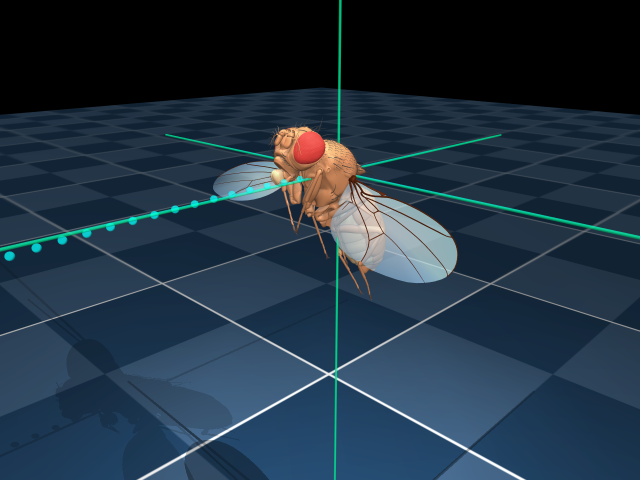

In [9]:
env = flight_imitation(wpg_pattern_path,
                       ref_flight_path,
                       terminal_com_dist=float('inf'))
env = wrappers.SinglePrecisionWrapper(env)
env = wrappers.CanonicalSpecWrapper(env, clip=True)

_ = env.reset()
pixels = env.physics.render(camera_id=1, **render_kwargs)
PIL.Image.fromarray(pixels)

Create dummy random-action policy, run episode, and make video. The gray "ghost" fly indicates the reference fly position, which the model is required to track.

In [ ]:
random_policy = get_random_policy(env.action_spec())

frames = rollout_and_render(env, random_policy, run_until_termination=True,
                            camera_ids=1, **render_kwargs)
display_video(frames)

Load trained policy, run episode, and make video.

In [ ]:
flight_policy = tf.saved_model.load(flight_policy_path)
# Wrap policy to work with non-batched observations at test time.
flight_policy = TestPolicyWrapper(flight_policy)

In [ ]:
frames = rollout_and_render(env, flight_policy, run_until_termination=True,
                            camera_ids=1, **render_kwargs)
display_video(frames)

# 2. Walking imitation environment

In this task, the fly model is required to track walking trajectories of real reference flies by matching their (i) center-of-mass position, (ii) body orientation, and (iii) detailed leg movement. A single policy is trained to track all trajectories in the walking dataset.

Let's create walking environment and visualize the initial state.

In [13]:
env = walk_imitation(ref_path=ref_walking_path,
                     terminal_com_dist=float('inf'))
env = wrappers.SinglePrecisionWrapper(env)
env = wrappers.CanonicalSpecWrapper(env, clip=True)

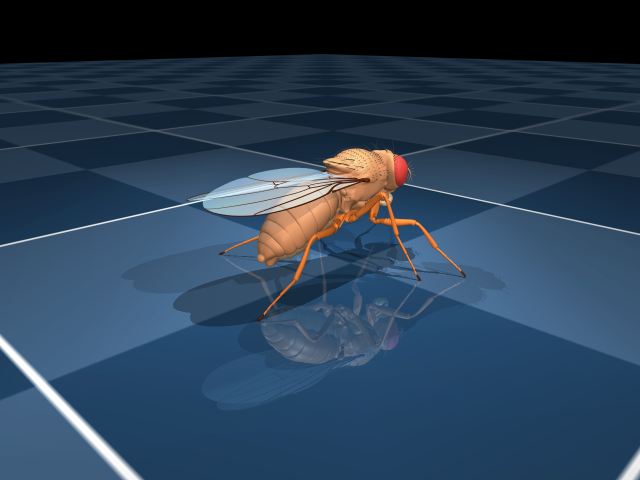

In [16]:
_ = env.reset()
pixels = env.physics.render(camera_id=1, **render_kwargs)
PIL.Image.fromarray(pixels)

Create a dummy random-action policy, run an episode, and make video. The gray "ghost" fly indicates the reference fly position. Here, we will create a slightly different version of the random-action policy by shifting the random actions to make the video pretty.

In [ ]:
_random_policy = get_random_policy(env.action_spec(),
                                   minimum=-.5, maximum=.5)
def random_policy(observation):
    action = _random_policy(observation)
    # Transform random action centered around zero to canonical representation
    # to match CanonicalSpecWrapper we added to the walking environment above.
    action = real2canonical(action, env._environment.action_spec())
    return action

# Request a particular (sufficiently long) walking trajectory from dataset.
env.task.set_next_trajectory_index(idx=316)

frames = rollout_and_render(env, random_policy, run_until_termination=True,
                            camera_ids=2, **render_kwargs)
display_video(frames)

Let's load a trained policy, run an episode, and make video.

In [18]:
walking_policy = tf.saved_model.load(walk_policy_path)
walking_policy = TestPolicyWrapper(walking_policy)

In [ ]:
# Request a particular (sufficiently long) walking trajectory from dataset.
env.task.set_next_trajectory_index(idx=316)

frames = rollout_and_render(env, walking_policy, run_until_termination=True,
                            camera_ids=2, **render_kwargs)
display_video(frames)

# 3. Vision-guided flight over uneven terrain ("bumps")

In this task, the fly model is required to fly over an uneven sine-like terrain while maintaining a constant z-offset (height) w.r.t. the current terrain elevation. The model does not have direct access to its flight height. Instead, it has to learn to use vision to estimate the current height and to adjust it to match the current terrain elevation. Collision with terrain terminates the episode. The terrain shape is randomly re-generated in each episode.

Let's create "bumps" vision task environment and visualize the initial state.

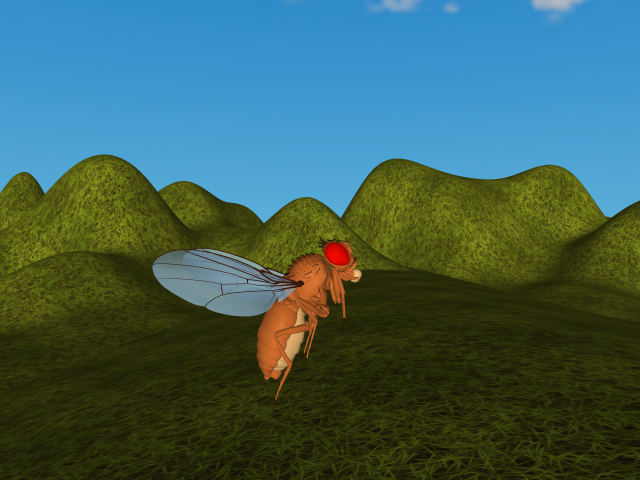

In [20]:
env = vision_guided_flight(wpg_pattern_path, bumps_or_trench='bumps')
env = wrappers.SinglePrecisionWrapper(env)
env = wrappers.CanonicalSpecWrapper(env, clip=True)

timestep = env.reset()
pixels = env.physics.render(camera_id=1, **render_kwargs)
PIL.Image.fromarray(pixels)

Let's render a high-resolution view from the eye cameras in the initial episode state

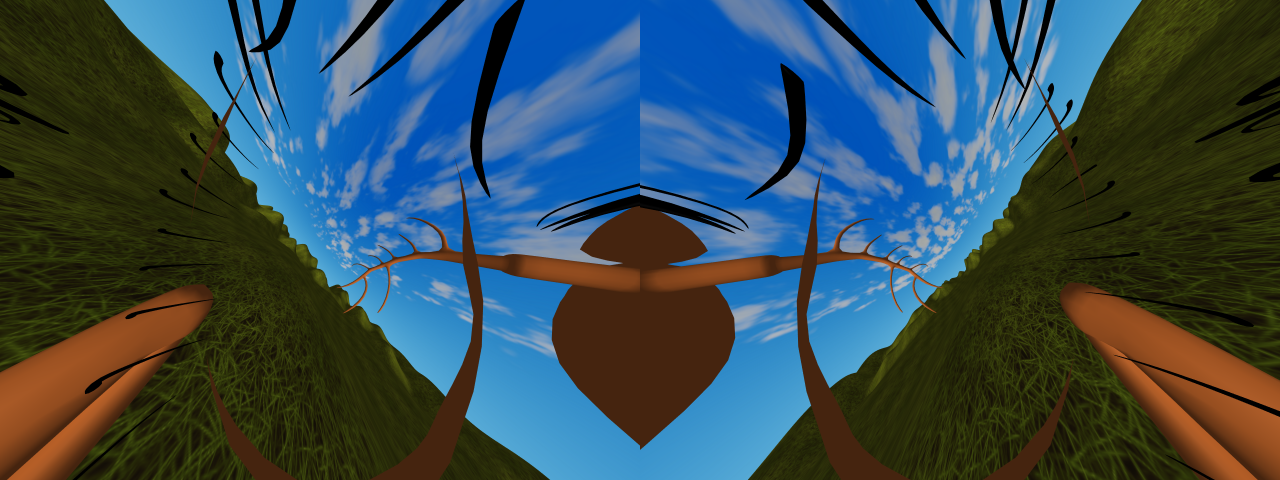

In [21]:
pixels = eye_pixels_from_cameras(env.physics, **render_kwargs)
PIL.Image.fromarray(pixels)

In the same initial episode state, the actual low-resolution view available to the fly through its observables looks more like this:

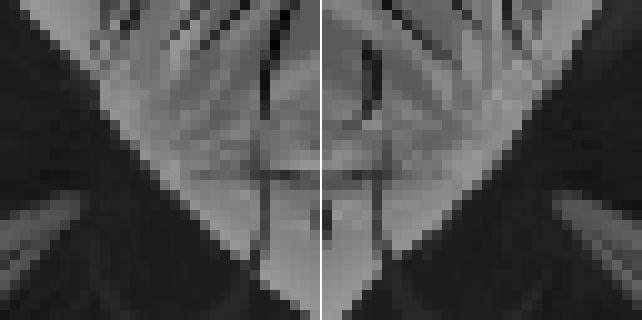

In [22]:
pixels = eye_pixels_from_observation(timestep, blow_factor=10)
PIL.Image.fromarray(pixels)

Create dummy random-action policy, run episode, and make video.

In [ ]:
random_policy = get_random_policy(env.action_spec())

frames = vision_rollout_and_render(env, random_policy, **render_kwargs)
display_video(frames)

Load a trained policy, run an episode, and make video:

In [25]:
bumps_policy = tf.saved_model.load(vision_bumps_path)
bumps_policy = TestPolicyWrapper(bumps_policy)

In [ ]:
frames = vision_rollout_and_render(env, bumps_policy, **render_kwargs)
display_video(frames)

# 4. Vision-guided flight through trench

In this task, the fly is required to make it through a zigzagging trench without colliding with the trench walls. Touching the terrain or the trench walls terminates the episode. The fly has to learn to use vision to estimate its position within the trench and to maneuver to stay clear of the trench walls. The shape of the trench is randomly re-generated in each episode.

Let's create the "trench" task environment and visualize the initial state

In [28]:
env = vision_guided_flight(wpg_pattern_path, bumps_or_trench='trench')
env = wrappers.SinglePrecisionWrapper(env)
env = wrappers.CanonicalSpecWrapper(env, clip=True)

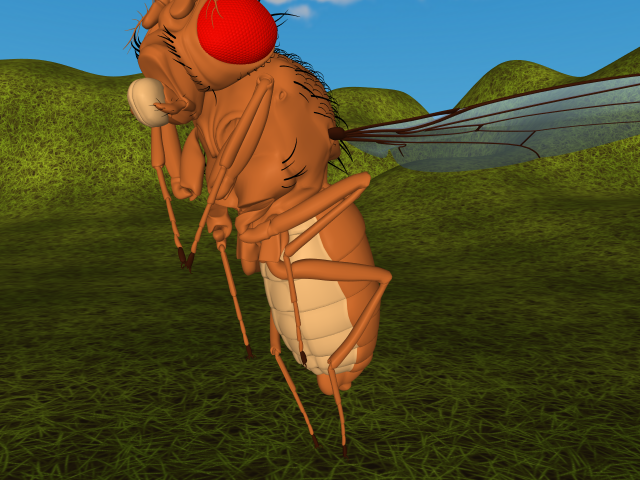

In [30]:
_ = env.reset()
pixels = env.physics.render(camera_id=6, **render_kwargs)
PIL.Image.fromarray(pixels)

Let's add a new tracking camera for better trench task visualization:

In [31]:
# Find thorax and add tracking camera to it.
thorax = env.task.root_entity.mjcf_model.find('body', 'walker/thorax')
_ = thorax.add('camera', name='rear', mode='trackcom',
               pos=(-1.566, 0.037, -0.021),
               xyaxes=(-0.014, -1, 0, -0.012, 0, 1))

Visualize the initial state with the new camera:

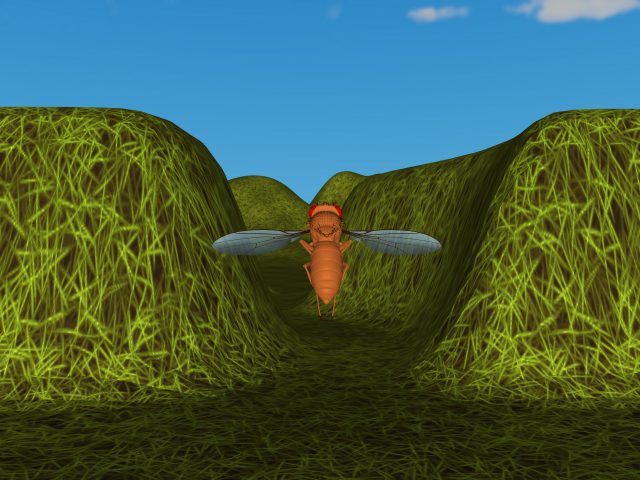

In [34]:
timestep = env.reset()
trench_camera_id = env.physics.model.name2id('walker/rear', 'camera')
pixels = env.physics.render(camera_id=trench_camera_id, **render_kwargs)
PIL.Image.fromarray(pixels)

Let's render a high-resolution view from the eye cameras in the initial episode state:

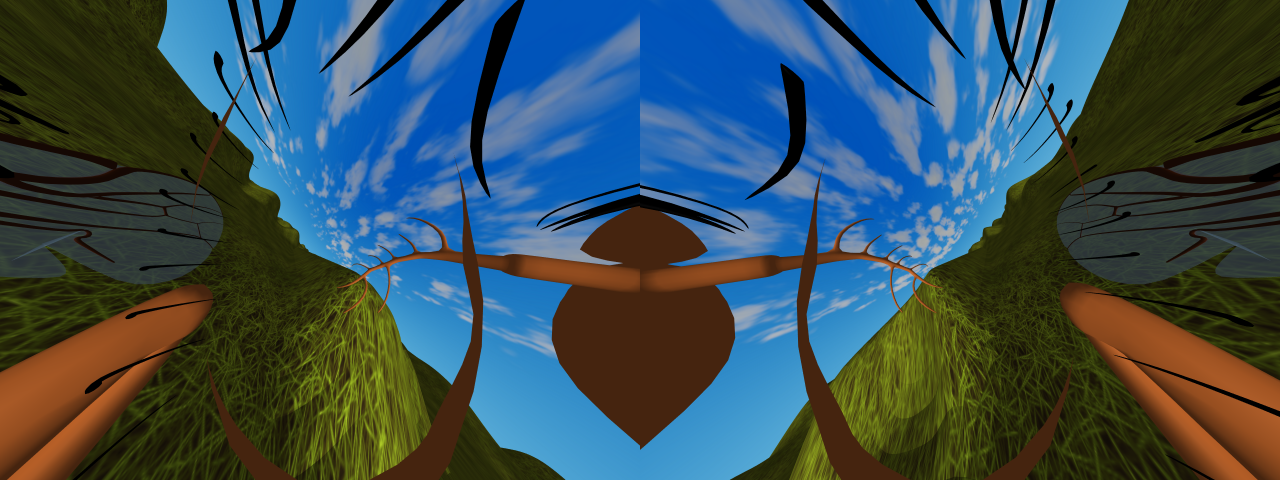

In [35]:
pixels = eye_pixels_from_cameras(env.physics, **render_kwargs)
PIL.Image.fromarray(pixels)

And the corresponding low-resolution view used by the fly model:

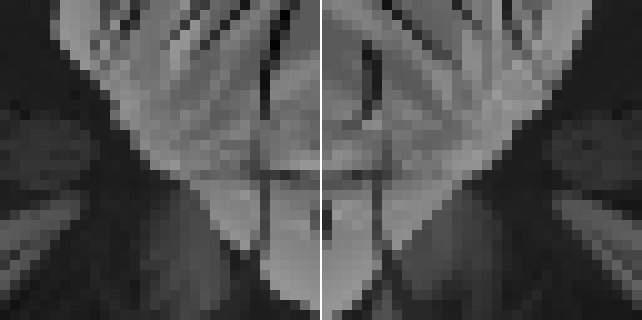

In [36]:
pixels = eye_pixels_from_observation(timestep, blow_factor=10)
PIL.Image.fromarray(pixels)

As before, let's run an episode with the random-action policy:

In [ ]:
random_policy = get_random_policy(env.action_spec())

frames = vision_rollout_and_render(
    env, random_policy, camera_id=trench_camera_id, **render_kwargs)
display_video(frames)

Let's load a trained policy and run an episode:

In [38]:
trench_policy = tf.saved_model.load(vision_trench_path)
trench_policy = TestPolicyWrapper(trench_policy)

In [ ]:
frames = vision_rollout_and_render(
    env, trench_policy, camera_id=trench_camera_id, **render_kwargs)
display_video(frames)

Thank you! We are happy you are interested in our fly model:)